# RL coursework, part I (20 pts total)
---


**Name:** Yuan Lu

**SN:** 20114649

---

**Due date:** *April 10th, 2025*

---
Standard UCL policy (including grade deductions) automatically applies for any late submissions.


## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part1.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

----
**Reminder of copyrights**

Copyrights protect this code/content and distribution or usages of it (or parts of it) without permission is prohibited. This includes uploading it and usage of it in training in any LLMs systems.

**Context**

In this assignment, we will take a first look at learning decisions from data.  For this, we will use the multi-armed bandit framework.

**Background reading**

* Sutton and Barto (2018), Chapters 1 to 6
* Lecture slides

**Overview of this assignment**

A) You will use Python to implement several bandit algorithms.

B) You will then run these algorithms on a multi-armed Bernoulli bandit problem, and answer question about their empirical performance.

C) You will then be asked to reason about the behaviour of different algorithms

## Setup

Run each of the cells below, until you reach the next section **Basic Agents**. You do not have to read or understand the code in the **Setup** section.  After running the cells, feel free to fold away the **Setup** section.

In [1]:
# Import Useful Libraries

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # Import Seaborn
from functools import partial
import collections

np.set_printoptions(precision=3, suppress=1)
sns.set_theme(style="white")

In [2]:
class BernoulliBandit(object):
  """A stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities, success_reward=1., fail_reward=0.):
    """Constructor of a stationary Bernoulli bandit.

    Args:
    success_probabilities: A list or numpy array containing the probabilities,
    for each of the arms, of providing a success reward.
    success_reward: The reward on success (default: 1.)
    fail_reward: The reward on failure (default: 0.)
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f
    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()


In [3]:
class NonStationaryBandit(object):
  """A non-stationary multi-armed Bernoulli bandit."""

  def __init__(self, success_probabilities,
               success_reward=1., fail_reward=0., change_point=800,
               change_is_good=True):
    """Constructor of a non-stationary Bernoulli bandit.

    Args:
      success_probabilities: A list or numpy array containing the probabilities,
          for each of the arms, of providing a success reward.
      success_reward: The reward on success (default: 1.)
      fail_reward: The reward on failure (default: 0.)
      change_point: The number of steps before the rewards change.
      change_is_good: Whether the rewards go up (if True), or flip (if False).
    """
    self._probs = success_probabilities
    self._number_of_arms = len(self._probs)
    self._s = success_reward
    self._f = fail_reward
    self._change_point = change_point
    self._change_is_good = change_is_good
    self._number_of_steps_so_far = 0

    ps = np.array(success_probabilities)
    self._values = ps * success_reward + (1 - ps) * fail_reward

  def step(self, action):
    """The step function.

    Args:
      action: An integer or np.int32 that specifies which arm to pull.

    Returns:
      A reward sampled according to the success probability of the selected arm.

    Raises:
      ValueError: when the provided action is out of bounds.
    """
    if action < 0 or action >= self._number_of_arms:
      raise ValueError('Action {} is out of bounds for a '
                       '{}-armed bandit'.format(action, self._number_of_arms))

    self._number_of_steps_so_far += 1
    success = bool(np.random.random() < self._probs[action])
    reward = success * self._s + (not success) * self._f

    if self._number_of_steps_so_far == self._change_point:
      # After some number of steps, the rewards are inverted
      #
      #  ``The past was alterable. The past never had been altered. Oceania was
      #    at war with Eastasia. Oceania had always been at war with Eastasia.``
      #            - 1984, Orwell (1949).
      reward_dif = (self._s - self._f)
      if self._change_is_good:
        self._f = self._s + reward_dif
      else:
        self._s -= reward_dif
        self._f += reward_dif

      # Recompute expected values when the rewards change
      ps = np.array(self._probs)
      self._values = ps * self._s + (1 - ps) * self._f

    return reward

  def regret(self, action):
    """Computes the regret for the given action."""
    return self._values.max() - self._values[action]

  def optimal_value(self):
    """Computes the regret for the given action."""
    return self._values.max()

In [4]:
# Helper functions

def smooth(array, smoothing_horizon=100., initial_value=0.):
  """Smoothing function for plotting."""
  smoothed_array = []
  value = initial_value
  b = 1./smoothing_horizon
  m = 1.
  for x in array:
    m *= 1. - b
    lr = b/(1 - m)
    value += lr*(x - value)
    smoothed_array.append(value)
  return np.array(smoothed_array)

def plot(algs, plot_data, repetitions=30):
  """Plot results of a bandit experiment."""
  algs_per_row = 4
  n_algs = len(algs)
  n_rows = (n_algs - 2)//algs_per_row + 1
  fig = plt.figure(figsize=(10, 4*n_rows))
  fig.subplots_adjust(wspace=0.3, hspace=0.35)
  clrs = ['#000000', '#00bb88', '#0033ff', '#aa3399', '#ff6600']
  lss = ['--', '-', '-', '-', '-']
  for i, p in enumerate(plot_data):
    for c in range(n_rows):
      ax = fig.add_subplot(n_rows, len(plot_data), i + 1 + c*len(plot_data))
      ax.grid(0)

      current_algs = [algs[0]] + algs[c*algs_per_row + 1:(c + 1)*algs_per_row + 1]
      for alg, clr, ls in zip(current_algs, clrs, lss):
        data = p.data[alg.name]
        m = smooth(np.mean(data, axis=0))
        s = np.std(smooth(data.T).T, axis=0)/np.sqrt(repetitions)
        if p.log_plot:
          line = plt.semilogy(m, alpha=0.7, label=alg.name,
                              color=clr, ls=ls, lw=3)[0]
        else:
          line = plt.plot(m, alpha=0.7, label=alg.name,
                          color=clr, ls=ls, lw=3)[0]
          plt.fill_between(range(len(m)), m + s, m - s,
                           color=line.get_color(), alpha=0.2)
      if p.opt_values is not None:
        plt.plot(p.opt_values[current_algs[0].name][0], ':', alpha=0.5,
                 label='optimal')

      ax.set_facecolor('white')
      ax.tick_params(axis="both", which="both", bottom="off", top="off",
                     labelbottom="on", left="off", right="off", labelleft="on")
      ax.spines["top"].set_visible(False)
      ax.spines["bottom"].set(visible=True, color='black', lw=1)
      ax.spines["right"].set_visible(False)
      ax.spines["left"].set(visible=True, color='black', lw=1)
      ax.get_xaxis().tick_bottom()
      ax.get_yaxis().tick_left()

      data = np.array([smooth(np.mean(d, axis=0)) for d in p.data.values()])

      if p.log_plot:
        start, end = calculate_lims(data, p.log_plot)
        start = np.floor(np.log10(start))
        end = np.ceil(np.log10(end))
        ticks = [_*10**__
                 for _ in [1., 2., 3., 5.]
                 for __ in [-2., -1., 0.]]
        labels = [r'${:1.2f}$'.format(_*10** __)
                  for _ in [1, 2, 3, 5]
                  for __ in [-2, -1, 0]]
        plt.yticks(ticks, labels)
      plt.ylim(calculate_lims(data, p.log_plot))
      plt.locator_params(axis='x', nbins=4)

      plt.title(p.title)
      if i == len(plot_data) - 1:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

def run_experiment(bandit_constructor, algs, repetitions, number_of_steps):
  """Run multiple repetitions of a bandit experiment."""
  reward_dict = {}
  regret_dict = {}
  optimal_value_dict = {}

  for alg in algs:
    reward_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    regret_dict[alg.name] = np.zeros((repetitions, number_of_steps))
    optimal_value_dict[alg.name] = np.zeros((repetitions, number_of_steps))

    for _rep in range(repetitions):
      bandit = bandit_constructor()
      alg.reset()

      action = None
      reward = None
      for _step in range(number_of_steps):
        action = alg.step(action, reward)
        reward = bandit.step(action)
        regret = bandit.regret(action)
        optimal_value = bandit.optimal_value()

        reward_dict[alg.name][_rep, _step] = reward
        regret_dict[alg.name][_rep, _step] = regret
        optimal_value_dict[alg.name][_rep, _step] = optimal_value

  return reward_dict, regret_dict, optimal_value_dict


def train_agents(agents, number_of_arms, number_of_steps, repetitions=100,
                 success_reward=1., fail_reward=0.,
                 bandit_class=BernoulliBandit):

  success_probabilities = np.arange(0.3, 0.7 + 1e-6, 0.4/(number_of_arms - 1))

  bandit_constructor = partial(bandit_class,
                               success_probabilities=success_probabilities,
                               success_reward=success_reward,
                               fail_reward=fail_reward)
  rewards, regrets, opt_values = run_experiment(
      bandit_constructor, agents, repetitions, number_of_steps)

  smoothed_rewards = {}
  for agent, rs in rewards.items():
    smoothed_rewards[agent] = np.array(rs)

  PlotData = collections.namedtuple('PlotData',
                                    ['title', 'data', 'opt_values', 'log_plot'])
  total_regrets = dict([(k, np.cumsum(v, axis=1)) for k, v in regrets.items()])
  plot_data = [
      PlotData(title='Smoothed rewards', data=smoothed_rewards,
               opt_values=opt_values, log_plot=False),
      PlotData(title='Current Regret', data=regrets, opt_values=None,
               log_plot=True),
      PlotData(title='Total Regret', data=total_regrets, opt_values=None,
               log_plot=False),
  ]

  plot(agents, plot_data, repetitions)

def calculate_lims(data, log_plot=False):
  y_min = np.min(data)
  y_max = np.max(data)
  diff = y_max - y_min
  if log_plot:
    y_min = 0.9*y_min
    y_max = 1.1*y_max
  else:
    y_min = y_min - 0.05*diff
    y_max = y_max + 0.05*diff
  return y_min, y_max

def argmax(array):
  """Returns the maximal element, breaking ties randomly."""
  return np.random.choice(np.flatnonzero(array == array.max()))

# A) Agent implementations


All agents should be in pure Python/NumPy.

You cannot use any AutoDiff packages (Jax, TF, PyTorch, etc.)

Each agent, should implement the following methods:

**`step(self, previous_action, reward)`:**

Should update the statistics by updating the value for the previous_action towards the observed reward.

(Note: make sure this can handle the case that previous_action=None, in which case no statistics should be updated.)

(Hint: you can split this into two steps: 1. update values, 2. get new action.  Make sure you update the values before selecting a new action.)

**`reset(self)`:**

Resets statistics (should be equivalent to constructing a new agent from scratch).

Make sure that the initial values (after a reset) are all zero.

**`__init__(self, name, number_of_arms, *args)`:**

The `__init__` should take at least an argument `number_of_arms`, and (potentially) agent specific args.

## Example agent

The following code block contains an example random agent.

In [5]:
class Random(object):
  """A random agent.

  This agent returns an action between 0 and 'number_of_arms', uniformly at
  random. The 'previous_action' argument of 'step' is ignored.
  """

  def __init__(self, name, number_of_arms):
    """Initialise the agent.

    Sets the name to `random`, and stores the number of arms. (In multi-armed
    bandits `arm` is just another word for `action`.)
    """
    self._number_of_arms = number_of_arms
    self.name = name

  def step(self, unused_previous_action, unused_reward):
    """Returns a random action.

    The inputs are ignored, but this function still requires an action and a
    reward, to have the same interface as other agents who may use these inputs
    to learn.
    """
    return np.random.randint(self._number_of_arms)

  def reset(self):
    pass


## Q1 [2 pts]
Implement a UCB agent.

The `bonus_multiplier` is the parameter $c$ from the slides.

In [6]:
class UCB(object):
  def __init__(self, name, number_of_arms, bonus_multiplier):
    self._number_of_arms = number_of_arms
    self._bonus_multiplier = bonus_multiplier
    self.name = name
    self.reset()

  def step(self, previous_action, reward):
    # If an action was previously taken, update its statistics.
    if previous_action is not None:
        self._N[previous_action] += 1
        # Incremental update of estimated value for the arm.
        self._Q[previous_action] += (reward - self._Q[previous_action]) / self._N[previous_action]

    # Increase the time counter (number of steps taken so far)
    self._time += 1

    # Compute UCB values for each arm
    ucb_values = np.zeros(self._number_of_arms)
    for i in range(self._number_of_arms):
        if self._N[i] == 0:
            # Ensure each arm is pulled at least once
            ucb_values[i] = float('inf')
        else:
            bonus = self._bonus_multiplier * np.sqrt(np.log(self._time) / self._N[i])
            ucb_values[i] = self._Q[i] + bonus

    # Choose the arm with the highest UCB value (break ties randomly)
    action = np.random.choice(np.flatnonzero(ucb_values == ucb_values.max()))
    return action

  def reset(self):
    # Reset estimates and counts; initial estimates are all 0.
    self._Q = np.zeros(self._number_of_arms)
    self._N = np.zeros(self._number_of_arms)
    self._time = 0

## Q2 [1 pt]
Implement an $\epsilon$-greedy agent.

This agent should be able to support time-changing $\epsilon$ schedules.

Thus, your agent should accept both constants and callables as constructor argument `epsilon`; callables are used to decay the $\epsilon$ parameter over time, for instance according to a polynomial schedule: $\epsilon_t = t^{-\eta}$ with $\eta \in [0, 1]$).


If multiple actions have the same value, ties should be broken randomly.

In [7]:
class EpsilonGreedy(object):
  """An epsilon-greedy agent.

  This agent returns an action between 0 and 'number_of_arms'; with probability
  `(1-epsilon)` it chooses the action with the highest estimated value, while
  with probability `epsilon` it samples an action uniformly at random.
  """

  def __init__(self, name, number_of_arms, epsilon=0.1):
    self.name = name
    self._number_of_arms = number_of_arms
    self._epsilon = epsilon  # Can be a constant or a callable schedule.
    self.reset()

  def step(self, previous_action, reward):
    """Update the learnt statistics and return an action.

    A single call to step uses the provided reward to update the value of the
    taken action (which is also provided as an input), and returns an action.
    The action is either uniformly random (with probability epsilon), or greedy
    (with probability 1 - epsilon).

    If the input action is None (typically on the first call to step), then no
    statistics are updated, but an action is still returned.
    """
    # If an action was taken previously, update its statistics.
    if previous_action is not None:
        self._N[previous_action] += 1
        self._Q[previous_action] += (reward - self._Q[previous_action]) / self._N[previous_action]

    self._time += 1

    # Determine the current epsilon value: evaluate if callable, else use constant.
    if callable(self._epsilon):
        current_epsilon = self._epsilon(self._time)
    else:
        current_epsilon = self._epsilon

    # With probability ε, choose a random action (exploration)
    if np.random.random() < current_epsilon:
        action = np.random.randint(self._number_of_arms)
    else:
        # Otherwise, choose the best action (exploitation). Ties are broken randomly.
        action = np.random.choice(np.flatnonzero(self._Q == self._Q.max()))
    return action

  def reset(self):
    # Reset estimated values and counts. Initial estimates are all 0.
    self._Q = np.zeros(self._number_of_arms)
    self._N = np.zeros(self._number_of_arms)
    self._time = 0

## Q3 [2 pts]
Implement a REINFORCE agent.

While `softmax` distributions are a common parametrization for policies over discrete action-spaces, they are not the only choice. In this exercise we ask you to implement REINFORCE with the `square-max` policy parameterization. With this parametrisation the probabilities depend on the action preferences $p(\cdot)$ according to the expression:

$$\pi(a) = \frac{p(a)^2}{\sum_b p(b)^2}\,.$$

Implement a REINFORCE policy-gradient method for updating the preferences under this policy distribution. The action preferences are stored separately, so that for each action $a$ the preference $p(a)$ is a single value that you directly update.

The agent should be able to use a baseline or not (as defined in the constructor). The `step_size` parameter $\alpha$ used to update the policy must also be configurable in the constructor.

The baseline should track the average reward so far, using the same `step_size` used to update the policy.

The `step_size` and whether or not a baseline is used are defined in the constructor by feeding additional arguments in place of `...` below.


In [8]:
class REINFORCE(object):
  def __init__(self, name, number_of_arms, step_size=0.1, baseline=False):
    self.name = name
    self._number_of_arms = number_of_arms
    self.step_size = step_size
    self.use_baseline = baseline
    self.reset()

  def step(self, previous_action, reward):
    # If this is not the first step, update the policy parameters.
    if previous_action is not None:
        # Compute normalization constant Z = sum_b p(b)^2.
        Z = np.sum(self.preferences**2)

        # Determine the reward signal (with baseline if enabled).
        if self.use_baseline:
            # Update baseline using the same step size.
            self.baseline += self.step_size * (reward - self.baseline)
            delta = reward - self.baseline
        else:
            delta = reward

        # Update preferences for each action.
        for b in range(self._number_of_arms):
            if b == previous_action:
                # Gradient for the taken action.
                grad = 2.0 / self.preferences[b] - 2.0 * self.preferences[b] / Z
            else:
                # Gradient for the actions not taken.
                grad = -2.0 * self.preferences[b] / Z
            self.preferences[b] += self.step_size * delta * grad

    # Compute current policy probabilities using the square-max parameterization.
    Z_new = np.sum(self.preferences**2)
    probs = (self.preferences**2) / Z_new

    # Sample an action from the policy (ties are naturally handled by np.random.choice).
    action = np.random.choice(self._number_of_arms, p=probs)
    return action

  def reset(self):
    # Initialize preferences to 1 to ensure valid probabilities (nonzero when squared).
    self.preferences = np.ones(self._number_of_arms)
    if self.use_baseline:
        self.baseline = 0.0

# B) Experiments

**Run the cell below to train the agents and generate the plots for the first experiment.**

Trains the agents on a Bernoulli bandit problem with 5 arms,
with a reward on success of 1, and a reward on failure of 0.

## Experiment 1: Bernoulli bandit

In [9]:
%%capture experiment1

number_of_arms = 5
number_of_steps = 1000

agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0$",
        number_of_arms,
        epsilon=0.),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/t$",
        number_of_arms,
        epsilon=lambda t: 1./t),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=False),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),
]

train_agents(agents, number_of_arms, number_of_steps)

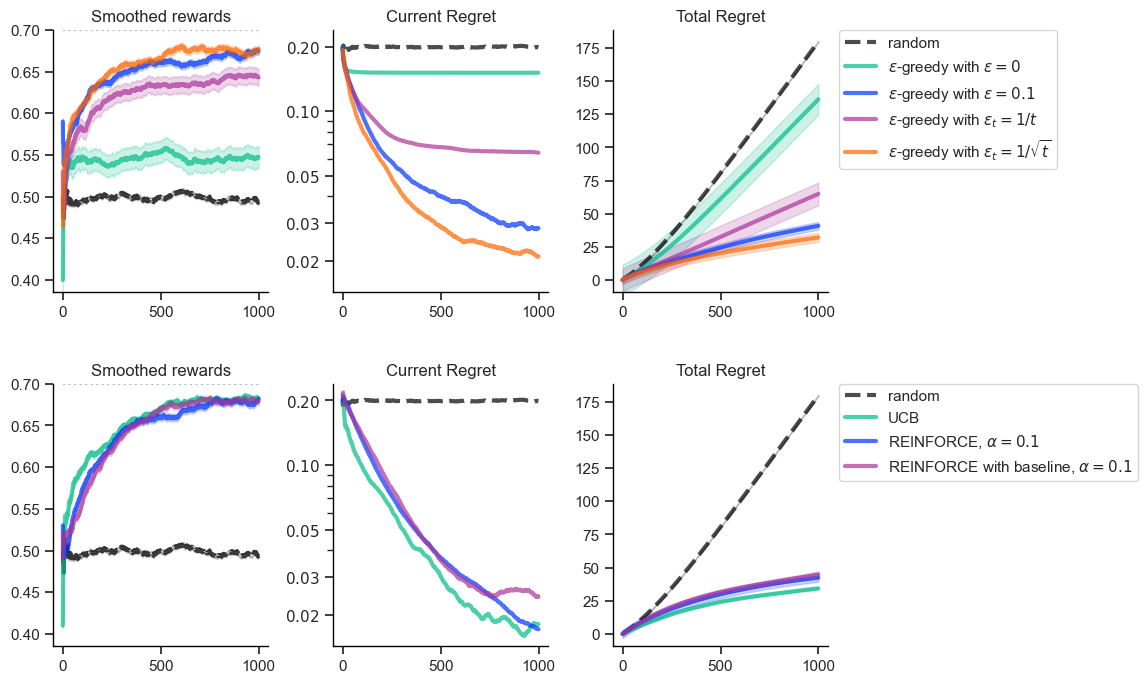

In [10]:
experiment1.show()

## Q4 [4 pts total]
(Answer inline in the markdown below each question, **within this text cell**.)

**[2 pts]**
For each algorithm in the plots above, explain whether or not we should be expected it to be good in general, in terms of total regret.

## Regret‑Based Evaluation of Algorithms
The algorithm's goal is to minimize the regret of the Bernoulli MAB, a 'good' algorithm need to balance exploration and exploitation. That is, it needs to maximize the action that would yeild the most reward and explore all possible actions with a reasonable amount of trials, so that any potential better action is not missed out, we will give a one short summary for each algorithm.

- **Greedy (ε=0)**
  - Theoretical regret: Θ(T) (linear)
  - Expected behavior: No exploration → permanently stuck on whichever arm was sampled first
  - Comment: **Bad** — unbounded total regret

- **ε‑Greedy (fixed ε)**
  - Theoretical regret: Θ(εT) (linear)
  - Expected behavior: Constant random exploration → persistent suboptimal pulls
  - Comment: **Poor** — regret grows linearly

- **ε‑Greedy (ε = 1/t)**
  - Theoretical regret: O(log T) (sublinear)
  - Expected behavior: Rapidly decreasing exploration rate → sufficient early exploration then almost pure exploitation
  - Comment: **Reasonable** — achieves logarithmic regret like UCB but can under‑explore very early if rewards are noisy

- **ε‑Greedy (ε≈1/√t)**
  - Theoretical regret: O(log T) (sublinear)
  - Expected behavior: Gradually shifts from exploration to exploitation → diminishing per‑step regret
  - Comment: **Reasonable** — near‑optimal if decay is tuned correctly

- **UCB1**
  - Theoretical regret: O(log T) (minimax‑optimal)
  - Expected behavior: Systematic confidence‑bound exploration → provably minimal cumulative regret
  - Comment: **Excellent** — Optimal for regret minimization in this setup

- **REINFORCE (Policy Gradient)**
  - Theoretical regret: No standard bound
  - Expected behavior: High variance updates and slow convergence → large cumulative regret
  - Comment::️ **Weak** — not designed to minimize regret

- **REINFORCE with Baseline**
  - Theoretical regret: No standard bound
  - Expected behavior: Reduced variance vs vanilla PG but still lacks sublinear regret scaling
  - Comment: **Moderate** — better than plain PG but inferior to UCB and decaying ε‑greedy


In this Bernoulli MAB, the empirical results confirm our theoretical regret‑based predictions:

- The **Greedy** algorithm exhibits the highest total regret (linear growth), performing worst.
- **Fixed ε‑Greedy** likewise incurs large, approximately linear regret.
- Both **decaying ε‑Greedy** variants (ε=1/√t and ε=1/t) achieve sublinear regret, reducing cumulative regret over time as expected.
- **UCB1** attains the lowest total regret at T=1000, consistent with its optimal O(log T) guarantee.
- **REINFORCE with baseline** performs comparably to decaying ε‑Greedy but remains behind UCB1 in regret minimization.


**[2 pts]** Explain the relative ranking of the $\epsilon$-greedy algorithms in this experiment.
1. **ε‑Greedy (ε = 1/√t)**
   - **Regret bound:** O(log T) (sublinear, asymptotically optimal)
   - **Exploration schedule:** Decays slowly enough to ensure sufficient early exploration while rapidly focusing on exploitation
   - **Finite‑time behavior:** Lowest cumulative regret among ε‑Greedy variants because it balances exploration/exploitation optimally

2. **ε‑Greedy (ε = 0.1)**
   - **Regret bound:** Θ(εT) = Θ(T) (linear regret, not asymptotically optimal)
   - **Exploration schedule:** Constant exploration → steady but small probability of suboptimal pulls
   - **Finite‑time behavior:** Lower regret than rapidly decaying schedules (ε=1/t) for practical horizons, since it avoids premature convergence

3. **ε‑Greedy (ε = 1/t)**
   - **Regret bound:** O(log T) (sublinear in theory)
   - **Exploration schedule:** Decays too quickly → insufficient exploration early on
   - **Finite‑time behavior:** High initial regret because it locks in on early estimates; asymptotically optimal but poor practical performance

4. **Greedy (ε = 0)**
   - **Regret bound:** Θ(T) (linear regret, worst possible)
   - **Exploration schedule:** None → permanently exploits first sampled action
   - **Finite‑time behavior:** Highest cumulative regret; fails to discover better arms


## Experiment 2: reward = 0 on success, reward = -1 on failure.

**Run the cell below to train the agents and generate the plots for the second experiment.**
Reruns experiment 1 but on a different bernoulli bandit problem with 5 arms,
with a reward on success of 0, and a reward on failure of -1.

---



In [11]:
%%capture experiment2
number_of_arms = 5
number_of_steps = 1000

train_agents(agents, number_of_arms, number_of_steps,
             success_reward=0., fail_reward=-1.)

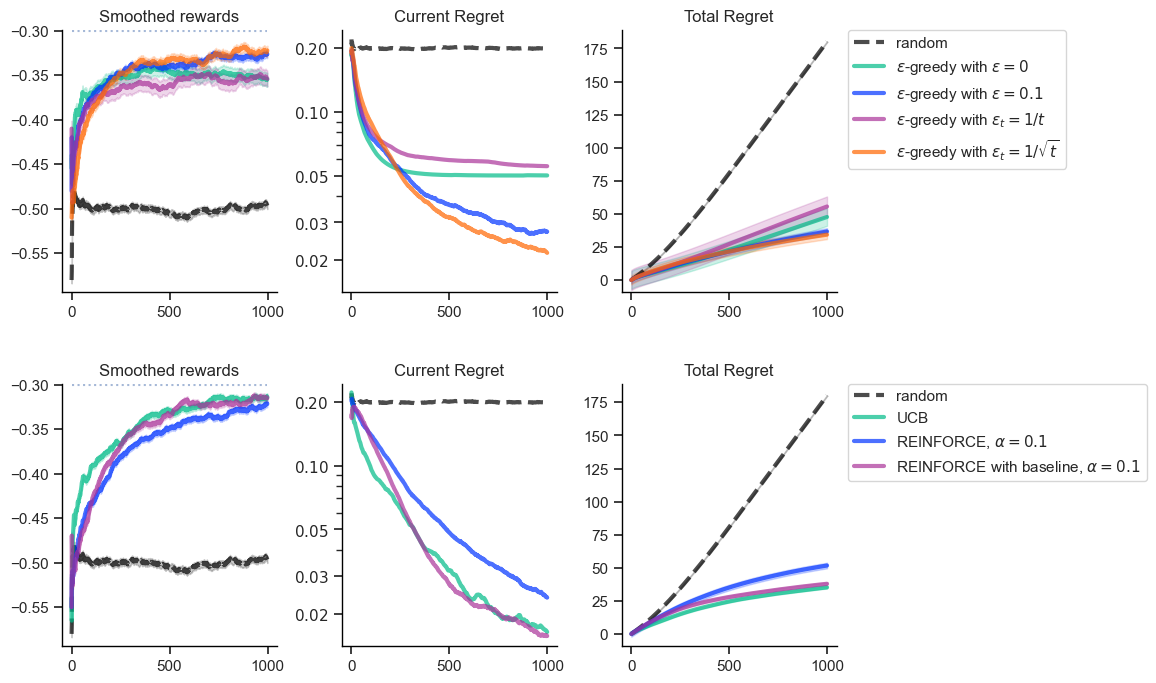

In [12]:
experiment2.show()

## Q5 [2 pts]
For each algorithm, note whether the performance changed significantly compared to the **experiment 1**, and explain why it did or did not.

(Use at most two sentences per algorithm).

- **UCB1 & ε‑Greedy (ε=1/√t):**
  Their regret bounds (O(log T)) depend only on relative reward differences, not absolute scale, so performance remains essentially unchanged — they continue to optimally trade off exploration and exploitation.

- **Greedy (ε=0):**
  Because untried arms start with Q=0 (optimistic relative to their true negative returns), pure greedy implicitly explores until observed rewards drop below 0, yielding far lower regret than in Experiment 1; this is a classic “optimistic initialization” effect.

- **ε‑Greedy (ε=0.1):**
  Constant exploration still induces linear regret, but finite‑time performance improves marginally because the baseline action-value (0) biases early choices toward unexplored arms longer, reducing early suboptimal pulls compared to Experiment 1.

- **ε‑Greedy (ε=1/t):**
  Rapidly decaying exploration now benefits from implicit exploration via optimistic initialization, so its finite‑time regret drops significantly; however, it still under‑explores relative to ε=0.1, preserving the same ranking.

- **REINFORCE (no baseline):**
  With only negative feedback (–1 for failures), vanilla policy gradient suffers high variance updates pushing probabilities downward without clear signal for the optimal arm, slightly degrading learning speed and increasing regret.

- **REINFORCE (with baseline):**
  The baseline centers returns around zero, allowing positive advantage for arms that avoid failures; this leverages the zero reward on success to accelerate convergence and reduce regret, bringing its performance closer to UCB.


## Run the following cells

## Experiment 3: Non-stationary bandit
 * Reward on `failure` changes from 0 to +2.
 * Reward on `success` remains at +1.


In [13]:
%%capture experiment3

number_of_arms = 3
number_of_steps = 1984
agents = [
    Random(
        "random",
        number_of_arms),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon=0.1$",
        number_of_arms,
        epsilon=0.1),
    EpsilonGreedy(
        r"$\epsilon$-greedy with $\epsilon_t=1/\sqrt{t}$",
        number_of_arms,
        epsilon=lambda t: 1./t**0.5),
    UCB("UCB",
        number_of_arms,
        bonus_multiplier=1/np.sqrt(2)),
    REINFORCE(
        r"REINFORCE with baseline, $\alpha=0.1$",
        number_of_arms,
        step_size=0.1,
        baseline=True),

]

roving_bandit_class = partial(NonStationaryBandit, change_is_good=True)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

## Experiment 4: Non-stationary bandit
 * Reward on `failure` changes from 0 to +1.
 * Reward on `success` changes from +1 to 0.


In [14]:
%%capture experiment4

number_of_arms = 3
number_of_steps = 1984


roving_bandit_class = partial(NonStationaryBandit, change_is_good=False)
train_agents(agents, number_of_arms, number_of_steps,
             bandit_class=roving_bandit_class)

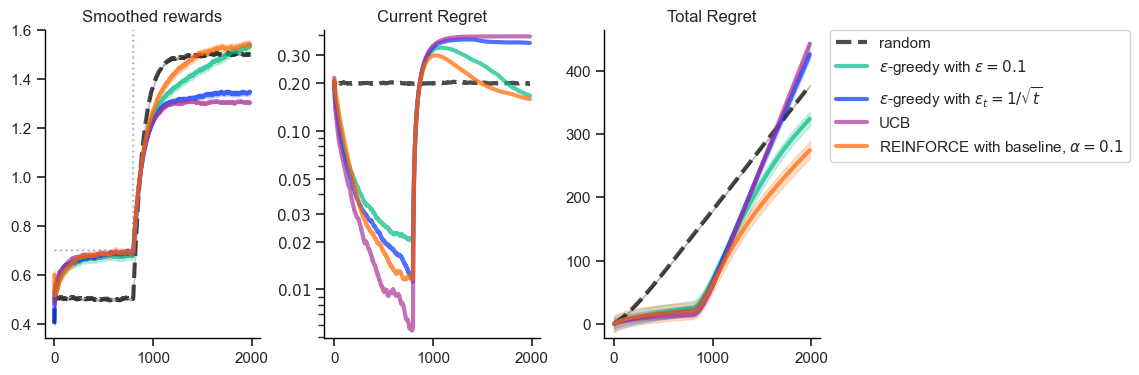

In [15]:
experiment3.show()

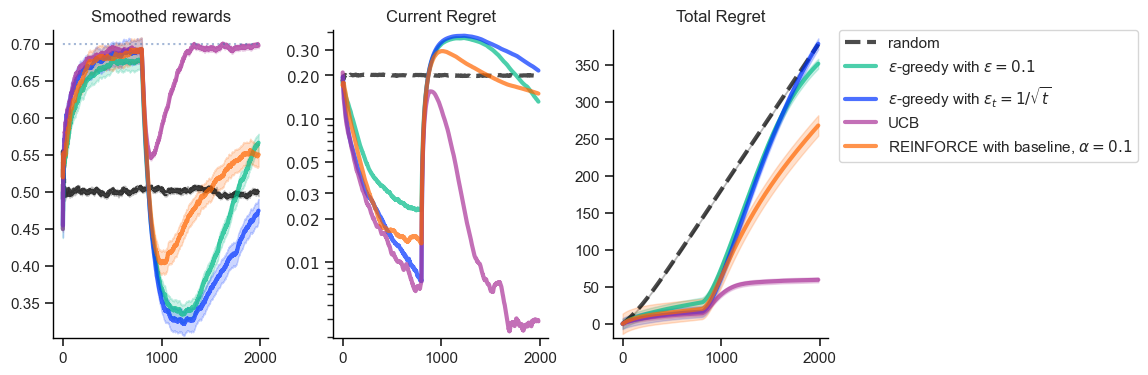

In [16]:
experiment4.show()

## Q6 [9 pts total]

Observe the reward and regret curves above.  After 800 steps, the rewards change. In **experiment 3** `success` continues to yield a reward of +1, but `failure` changes from a reward of 0 to a reward of +2.  In **experiment 4**, `success` is now worth 0 and `failure` is worth +1.

Below, we ask for explanations.  Answer each question briefly, using at most three sentences per question.

**[2 pts]** In **experiment 3** explain the ranking in current regret after the change in rewards for all algorithms.

> After 800 steps, “failure” becomes more profitable (+2) than “success” (+1), so algorithms that keep exploring (like ε‑greedy with ε=0.1) quickly discover that the formerly “worse” arms now yield higher reward. In contrast, methods that largely exploited one arm (e.g., UCB with a nearly solid estimate, or ε decaying too fast) fail to update their estimates in time and miss out on the new best arms. Hence, **constant ε‑greedy** stands out as best post‑change, while UCB, greedy, and decaying ε‑greedy lag behind.


**[2 pts]** In **experiment 4** explain the ranking in current regret after the change in rewards for all algorithms.

> Now “success” drops to 0 and “failure” rises to +1, so the previously optimal arms lose value and must be re‑explored. UCB systematically detects this drop faster than others because its upper confidence terms encourage trials of arms not recently sampled, swiftly adapting to the new reward landscape. REINFORCE and ε‑greedy also eventually adapt, but UCB leads due to its balanced exploration mechanism.


**[2 pts]** Explain how and why the current-regret curve for UCB in **experiment 3** differs from the curve in **experiment 4**.

> In **experiment 3**, UCB doesn’t see a downward shift in reward for the old “best” arms, so its estimated Q‑values remain high, causing slow adaptation to the new high‑reward “failure” arms. In **experiment 4**, those old arms’ rewards drop to 0, bringing their estimates down and triggering more exploration of other arms. This key difference—estimates decreasing in experiment 4 but not in experiment 3—explains why UCB adapts much more effectively in experiment 4.


**[3 pts]** In general, if rewards can be non-stationary, and we don't know the exact nature of the non-stationarity, how could we modify UCB to perform better?   Be specific and concise.

> A common approach is **Discounted UCB** (or “sliding‑window” UCB), which applies higher weight to recent observations and reduces the influence of outdated reward estimates. Concretely, one can either maintain a running window of the most recent samples (resetting arm counts and means periodically) or exponentially discount old rewards in the Q‑value updates. This ensures that when the environment shifts, the algorithm “forgets” stale data and adapts more quickly to new reward patterns.
